## Assignment 8
### Jeremy Kazimer
### jdkazime@buffalo.edu

#### _Import Statements_

In [4]:
# Data structures
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Plotting
from matplotlib import pyplot as plt

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-04-28 04:23:42,320: Credentials are already in use. The existing account in the session will be replaced.


#### _Introduction_

The premise of this problem is that we can turn a typical Mach-Zehnder Interferometer experiment into a quantum computation as opposed to that of a classical computer.  

Note that the gimmick of the Mach-Zehnder Inferferometer experiment is that light is traveling along a beam splitter such that light is broken down into two components:  a lower and upper path.  We denote these by their wave components such that
\begin{equation}
\psi_l = \begin{pmatrix} 0 \\ 1 \end{pmatrix}
\end{equation}

where $\psi_l$ is the lower portion.  Further
\begin{equation}
\psi_u = \begin{pmatrix} 1 \\ 0 \end{pmatrix}
\end{equation}

where $\psi_u$ is the upper portion.  The individual beams are then combined such that we can interpret the phase angle of the recombined beam.  We do this by calculating the probability $p(\psi)$ that a photon is in either the lower or upper branch, or $p(\psi_l$) and $p(\psi_u)$.  Consider that $p(\psi_l) + p(\psi_u) = 1$.   Then, we can use
\begin{equation}
p(\psi_l) = \sin^2\left(\dfrac{\Delta \Phi}{2}\right)
\end{equation}

or

\begin{equation}
p(\psi_u) = \cos^2\left(\dfrac{\Delta \Phi}{2}\right)
\end{equation}

to determine the angle such that $\Delta \Phi$ is the phase angle.  Note again that the sum of $\cos^2\left(\dfrac{\Delta \Phi}{2}\right) + \sin^2\left(\dfrac{\Delta \Phi}{2}\right) = 1$.  

The main thing is that a Hadamard (H) Gate is used such that it can superimpose the beams by the unitary matrix

\begin{equation}
H = \dfrac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1\end{bmatrix}
\end{equation}

With that, we can begin by creating a circuit:

#### _Creating the Circuit_

Note that this code was primarily taken from the `CompPhys` [GitHub repository](https://github.com/ubsuny/CompPhys), with changes made for my own purposes.

In [5]:
def create_circuit(number_phases, phase_angles):
    
    '''
        number_phases -> the number of phase modulations desired
        phase_angles -> the phases by which to modulate the beam
    '''
    
    circuit = QuantumCircuit(QuantumRegister(1), ClassicalRegister(1))

    circuit.h(0)
    
    for phase in range(number_phases):
        if len(phase_angles) == 1:
            circuit.p(phase_angles[0], 0)
        else: 
            circuit.p(phase_angles[phase], 0)
            
    circuit.h(0)

    circuit.measure([0], [0])

    return circuit

In [42]:
circuit = create_circuit(1, [np.pi/2])

Now, we can draw our circuit:

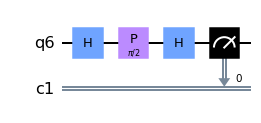

In [12]:
circuit.draw()

Okay, cool, but now we should actually use our circuit to simulate something.  Namely, we should start by generating probabilities:

In [13]:
def simulation_probabilities(circuit, iterations):
    
    '''
        circuit -> our circuit
        iterations -> number of times the circuit should be ran.
    '''
    
    simulator = QasmSimulator()

    compiled_circuit = transpile(circuit, simulator)
    
    job = simulator.run(compiled_circuit, shots = iterations)

    result = job.result()

    counts = result.get_counts(circuit)
    
    return counts

In [43]:
counts = simulation_probabilities(circuit, 1000)
print(counts)

{'1': 502, '0': 498}


We see that this is roughly a 50/50 split.  Due to the random nature of this process, it would be important to repeat this as many times, for as many different circuits with the same initial conditions, so that this number is rounded out.  Of course, space limitations apply.  

Regardless, we can now convert this into proper probabilities and the phase angles:

In [17]:
def get_phase_angle(counts):
    
    '''
        counts -> the distributions of upper and lower
    '''
    
    count_keys = counts.keys()
    if len(count_keys) == 2:
        c_l = counts['0']
        c_u = counts['1']
    else:
        if '0' in list(count_keys):
            c_l = counts['0']
            c_u = 0
        else:
            c_l = 0
            c_u = counts['1']
            
    total = c_l + c_u
    probabilities = (c_l/total, c_u/total)
    phase_angle = 2*np.arccos(np.sqrt(probabilities[0]))
    
    return probabilities, phase_angle

In [21]:
probabilities, phase_angle = get_phase_angle(counts)
print(probabilities)
print(phase_angle)

(0.511, 0.489)
1.548794551741596


Our probabilities are obvious, but how similar is this phase angle to the angle that we introduced?

In [22]:
print(abs(np.pi/2 - phase_angle))

0.022001775053300587


So, there is considerable error.  Hence, the need to repeat this enough so that this data is more well-rounded.  As such, we can treat this as a Monte Carlo problem by doing the following:

In [24]:
trials = 20

input_angles = np.linspace(0, 2*np.pi, 90)
probabilities = np.zeros((trials, 2, input_angles.shape[0]))
phase_angles = np.zeros((trials, input_angles.shape[0]))

iterations = 100
for trial in range(trials):
    print('on trial {} of {}'.format(trial + 1, trials), '\r', end = '')
    for idx, angle in enumerate(input_angles):

        circuit = create_circuit(1, [angle])
        counts = simulation_probabilities(circuit, iterations)
        probability, phase_angle = get_phase_angle(counts)

        probabilities[trial, :, idx] = probability
        phase_angles[trial, idx] = phase_angle    

Of course, since this a Monte Carlo simulation, an average should be taken:

In [25]:
p_means = probabilities.mean(axis = 0)
pa_means = phase_angles.mean(axis = 0)

And, a plot for good measure:

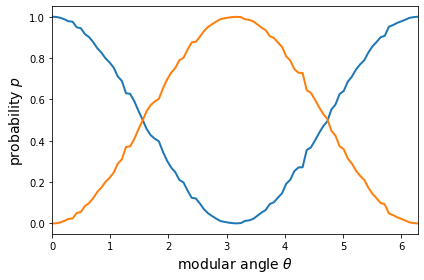

In [30]:
fig, ax = plt.subplots(1, 1)

ax.plot(input_angles, p_means.T, lw = 2)

ax.set_ylabel('probability $p$', fontsize = 14)
ax.set_xlabel(r'modular angle $\theta$', fontsize = 14)

ax.set_xlim(0, 2*np.pi)

fig.tight_layout()

This is great - it really shows constructive and destructive interference patterns.  But the big quesiton is always...what about our phase angle?

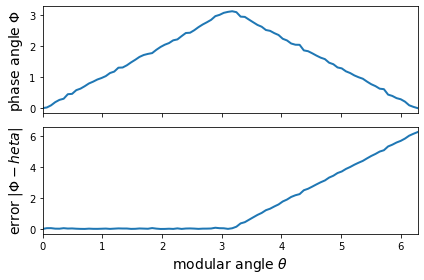

In [37]:
fig, axs = plt.subplots(2, 1, sharex = True)

axs[0].plot(input_angles, pa_means, lw = 2)

axs[0].set_ylabel('phase angle $\Phi$', fontsize = 14)

axs[1].plot(input_angles, abs(pa_means - input_angles), lw = 2)

axs[1].set_ylabel('error $|\Phi - \theta|$', fontsize = 14)
axs[1].set_xlabel(r'modular angle $\theta$', fontsize = 14)

axs[1].set_xlim(0, 2*np.pi)

fig.tight_layout()

So, it works.  It appears that my function fails because I exclusively use the $\cos^2\left(\dfrac{\Phi}{2}\right)$ function to calculate my phase angle.  So after $\pi$, the probabilities begin to decrease from the upper state again to the lower state.  As such, using only one of the functions cannot capture this.  It's important to note, so for this next and brief experiment I'll only exist on the domain $[0, \pi]$.  

Then, what's next? Well, we can briefly see how a linear combination of modulators fair, since we've only looked at one:

In [44]:
circuit = create_circuit(10, [np.pi/2])

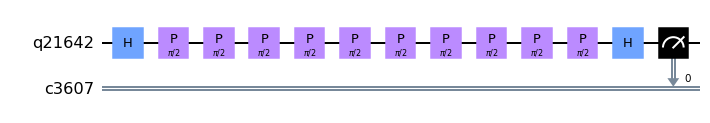

In [45]:
circuit.draw()

In [48]:
counts = simulation_probabilities(circuit, 1000)
print(counts)

{'1': 1000}


In [49]:
probabilities, phase_angle = get_phase_angle(counts)
print(probabilities)
print(phase_angle)

(0.0, 1.0)
3.141592653589793


Where did this come from? Well, $10 \times \dfrac{\pi}{2} = 5\pi$.  Note that $5\pi$ is coterminal with $\pi$, so this works out perfectly.  This does obey linearity.  As one last example, we could randomly perturb and verify that this absolutely works.  Therefore, the typical procedure.  However, this time I'm going to make the interval small enough so we don't have to worry about coterminal angles:

In [67]:
random_angles = np.random.uniform(0, 1, 5)

In [69]:
circuit = create_circuit(5, random_angles)

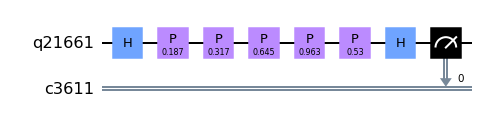

In [70]:
circuit.draw()

In [71]:
counts = simulation_probabilities(circuit, 1000)
print(counts)

{'0': 71, '1': 929}


In [74]:
probabilities, phase_angle = get_phase_angle(counts)
print(probabilities)
print(phase_angle)

(0.071, 0.929)
2.6021595395363257


The moment of truth...

In [75]:
print(np.sum(random_angles))

2.6421623335968882


Wow, so the system starts to fall apart...just one more verification.  If we make this interval fairly small, but repeated many times, what happens?

In [84]:
random_angles = np.random.uniform(0, 0.01, 500)

In [85]:
circuit = create_circuit(500, random_angles)

In [86]:
counts = simulation_probabilities(circuit, 1000)
print(counts)

{'0': 95, '1': 905}


In [87]:
probabilities, phase_angle = get_phase_angle(counts)
print(probabilities)
print(phase_angle)

(0.095, 0.905)
2.5149484419490524


In [88]:
print(np.sum(random_angles))

2.4561350518805387


The accuracy doesn't get worse.  And that makes sense for this scale.  It was important to check.  Perhaps it's not inaccurate at all and I'm just missing something.  Who knows! An overall fun experiment in what I would describe as dangerous territory this late in the semester. 